# **Importing Libraries**

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, AveragePooling2D, ZeroPadding2D
from sklearn.preprocessing import LabelEncoder

# **Reading Train and Validation Data**

In [2]:
# Reading Paths

train_dir = Path("../input/nn22-weather-analysis-using-image-recognition/Dataset/Train")
test_dir = Path("../input/nn22-weather-analysis-using-image-recognition/Dataset/Test")

In [3]:
# Get Images Dataframe

filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
file_path = pd.Series(filepaths, name = 'File_Path').astype(str)
labels = pd.Series(labels, name = 'Labels')
images = pd.concat([file_path, labels], axis = 1)
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,../input/nn22-weather-analysis-using-image-rec...,sandstorm
1,../input/nn22-weather-analysis-using-image-rec...,rime
2,../input/nn22-weather-analysis-using-image-rec...,dew
3,../input/nn22-weather-analysis-using-image-rec...,lightning
4,../input/nn22-weather-analysis-using-image-rec...,rain


In [4]:
# Splite Data into Train and Validation

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=2)
print("size of train dataframe: ", train_df["Labels"].size)
print("size of valid dataframe: ", valid_df["Labels"].size)

size of train dataframe:  4440
size of valid dataframe:  1111


In [5]:
# Reading Images Data

def read_data(data_frame): # data_frame param here can be train_df or valid_df
    X_image = []
    Y_label = []

    lbl = LabelEncoder()
    lbl.fit(list(data_frame["Labels"].values))
    data_frame["Labels"] = lbl.transform(list(data_frame["Labels"].values))
    X_arr = np.array(data_frame["File_Path"])
    Y_arr = np.array(data_frame["Labels"])


    for i in range (len(X_arr)):
        img_path = X_arr[i]
        img_label = Y_arr[i]

        try:
            x = cv2.imread(img_path)
            img_data = cv2.resize(x, (224, 224))
            img_data = img_data.reshape(224, 224, 3)
            X_image.append(np.array(img_data))

            # labels
            if img_label == 0:
                Y_label.append(np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
            elif img_label == 1:
                Y_label.append(np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
            elif img_label == 2:
                Y_label.append(np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
            elif img_label == 3:
                Y_label.append(np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))
            elif img_label == 4:
                Y_label.append(np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]))
            elif img_label == 5:
                Y_label.append(np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))
            elif img_label == 6:
                Y_label.append(np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
            elif img_label == 7:
                Y_label.append(np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]))
            elif img_label == 8:
                Y_label.append(np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]))
            elif img_label == 9:
                Y_label.append(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))
            elif img_label == 10:
                Y_label.append(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

        except:
            print("!!!Skipped Example Here!!!")

    print("The size of images: "+ str(len(X_image)))
    print("The size of Labels: "+ str(len(Y_label)))
    
    return X_image, Y_label

In [6]:
# Reading Data

print("The Training Data: ")
X_train, Y_train = read_data(train_df)
print("The Validation Data: ")
X_valid, Y_valid = read_data(valid_df)

The Training Data: 
!!!Skipped Example Here!!!
The size of images: 4439
The size of Labels: 4439
The Validation Data: 
The size of images: 1111
The size of Labels: 1111


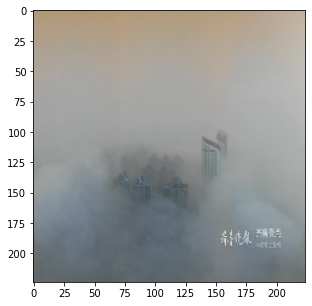

In [7]:
# Plotting one Image

plt.figure(figsize=(5, 5))
plt.imshow(X_train[0])
plt.show()

# **Creation of The Model**

In [8]:
# model creation

def create_model():
    
    #Instantiation
    AlexNet = Sequential()
    
    #1st Convolutional Layer
    AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    #2nd Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    #3rd Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    
    #4th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    
    #5th Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.4))
    
    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))
    
    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))
    
    #Output Layer
    AlexNet.add(Dense(11))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('softmax'))
    
    
    return AlexNet

In [9]:
# Access the Model

model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

2022-05-23 21:55:52.295225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 21:55:52.422504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 21:55:52.423239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 21:55:52.424394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
# get the summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

In [11]:
model.fit(
    np.array(X_train),
    np.array(Y_train),
    epochs=50,
    batch_size = 64,
    validation_data=(np.array(X_valid),np.array(Y_valid))
)

2022-05-23 21:55:56.645482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-23 21:55:58.986598: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


70/70 [==============================] - 13s 67ms/step - loss: 2.0281 - accuracy: 0.3384 - val_loss: 2.0785 - val_accuracy: 0.2430
Epoch 2/50
70/70 [==============================] - 4s 56ms/step - loss: 1.5951 - accuracy: 0.4947 - val_loss: 1.7720 - val_accuracy: 0.4788
Epoch 3/50
70/70 [==============================] - 4s 57ms/step - loss: 1.4599 - accuracy: 0.5614 - val_loss: 1.5585 - val_accuracy: 0.5563
Epoch 4/50
70/70 [==============================] - 4s 56ms/step - loss: 1.3589 - accuracy: 0.6139 - val_loss: 1.3816 - val_accuracy: 0.6391
Epoch 5/50
70/70 [==============================] - 4s 56ms/step - loss: 1.3094 - accuracy: 0.6294 - val_loss: 1.2858 - val_accuracy: 0.6652
Epoch 6/50
70/70 [==============================] - 4s 57ms/step - loss: 1.2562 - accuracy: 0.6580 - val_loss: 1.2478 - val_accuracy: 0.6706
Epoch 7/50
70/70 [==============================] - 4s 56ms/step - loss: 1.2139 - accuracy: 0.6844 - val_loss: 1.1948 - val_accuracy: 0.6841
Epoch 8/50
70/70 [=====

# **Calculate Training and Testing Accuracy**

In [12]:
# Calculate Accuracy

scores = model.evaluate(np.array(X_train), np.array(Y_train), verbose=0)
print("model train accuracy with built in func :-")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

scores = model.evaluate(np.array(X_valid),np.array(Y_valid), verbose=0)
print("model test accuracy with built in func :-")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

model train accuracy with built in func :-
accuracy: 99.77%
model test accuracy with built in func :-
accuracy: 75.79%


# **Prediction of test data**

In [13]:
# Prediction of test data

def predict_test_images():
    X_test_names = []
    Y_test_labels = []

    for img_name in os.listdir(test_dir):
        try:
            img_path = os.path.join(test_dir,img_name)
            x = cv2.imread(img_path)
            img_data = cv2.resize(x, (224, 224))
            img_data = img_data.reshape(224, 224, 3)

            lst = []
            lst.append(img_data)
            output_arr = model.predict(np.array(lst))
            label_num = np.argmax(np.array(output_arr))
            X_test_names.append(img_name)
            Y_test_labels.append(label_num)

        except:
            X_test_names.append(img_name)
            Y_test_labels.append(10)
            print("!!!Replaced Skipped Example Here with 0!!!")


    print("The Test images size: " + str(len(X_test_names)))
    print("The Test Labels size: " + str(len(Y_test_labels)))

    return X_test_names, Y_test_labels

In [14]:
# Create the Submission file

def create_submission_file(X_test_names, Y_test_labels):
    df = pd.DataFrame({'image_name': X_test_names,'label': Y_test_labels})
    df.to_csv(r'./CS_22_submission.csv', index=False)

In [15]:
# Prediction the test data and submission file

print("The Prediction of Test Data Starts...")
X_test_names, Y_test_labels = predict_test_images()
print("The Prediction of Test Data Ends")

print("the Submission file Creation Starts...")
create_submission_file(X_test_names, Y_test_labels)
print("the Submission file Created Successfully")

The Prediction of Test Data Starts...
!!!Replaced Skipped Example Here with 0!!!
The Test images size: 1300
The Test Labels size: 1300
The Prediction of Test Data Ends
the Submission file Creation Starts...
the Submission file Created Successfully
